# ReAct Pattern with Local Ollama Model

ReAct (Reasoning + Acting) 패턴을 **로컬 Ollama 모델**을 사용하여 구현합니다.

## 사전 요구사항
1. [Ollama](https://ollama.ai/) 설치
2. 모델 다운로드: `ollama pull gemma3:4b`
3. Ollama 서버 실행 중 (기본: http://localhost:11434)

## 지원 모델 (도구 호출 지원)
- `gemma3:4b` (추천 - 경량, 빠름)
- `llama3.1`
- `llama3.2`
- `mistral`
- `qwen2.5`

## 1. 환경 설정

In [ ]:
import os
from dotenv import load_dotenv

# .env 파일에서 환경변수 로드
load_dotenv()

# Ollama URL 설정 (기본값: localhost:11434)
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://localhost:11434")
print(f"Ollama URL: {OLLAMA_URL}")

# LangSmith 트레이싱 설정 확인
if os.getenv("LANGCHAIN_API_KEY"):
    print(f"LangSmith 트레이싱: 활성화")
    print(f"프로젝트: {os.getenv('LANGCHAIN_PROJECT', 'default')}")
else:
    print("LangSmith 트레이싱: 비활성화 (LANGCHAIN_API_KEY 없음)")

In [2]:
# Ollama 서버 연결 확인
import requests

try:
    response = requests.get(f"{OLLAMA_URL}/api/tags")
    if response.status_code == 200:
        models = response.json().get("models", [])
        print("Ollama 서버 연결 성공!")
        print(f"사용 가능한 모델: {[m['name'] for m in models]}")
    else:
        print(f"Ollama 서버 응답 오류: {response.status_code}")
except requests.exceptions.ConnectionError:
    print("Ollama 서버에 연결할 수 없습니다.")
    print("Ollama가 실행 중인지 확인해주세요: ollama serve")

Ollama 서버 연결 성공!
사용 가능한 모델: ['qwen3:8b', 'candiy:4b', 'candiy:12b', 'bge-m3:latest', 'sakak:8b', 'nomic-embed-text:latest', 'gemma3:12b', 'gemma3:4b', 'gemma3:1b', 'candiy:8b', 'candiy-insurance:8b', 'candiy:2b', 'aya:8b', 'llama3.2:1b', 'gemma2:2b']


## 2. 도구(Tools) 정의

ReAct 에이전트가 사용할 도구들을 정의합니다.

In [3]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Add two numbers together."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together."""
    return a * b


@tool
def divide(a: int, b: int) -> float:
    """Divide the first number by the second number."""
    if b == 0:
        return "Error: Cannot divide by zero."
    return a / b


@tool
def get_weather(city: str) -> str:
    """Get the current weather for a city. (Simulation)"""
    weather_data = {
        "seoul": "Sunny, 15°C",
        "busan": "Cloudy, 18°C",
        "jeju": "Rainy, 20°C",
        "daejeon": "Sunny, 16°C",
        "new york": "Cloudy, 10°C",
        "tokyo": "Sunny, 22°C",
    }
    return weather_data.get(city.lower(), f"Weather data not found for {city}.")


# 사용할 도구 목록
tools = [add, multiply, divide, get_weather]
print(f"정의된 도구: {[t.name for t in tools]}")

정의된 도구: ['add', 'multiply', 'divide', 'get_weather']


## 3. LLM 설정 (Local Ollama)

도구 호출을 지원하는 로컬 모델을 사용합니다.

In [ ]:
from langchain_ollama import ChatOllama

# 사용할 모델 선택 (도구 호출 지원 모델)
MODEL_NAME = "qwen3:8b"  # 또는 "llama3.1", "mistral", "qwen2.5" 등

# Ollama 모델 초기화
llm = ChatOllama(
    model=MODEL_NAME,
    base_url=OLLAMA_URL,
    temperature=0,  # 일관된 출력을 위해 0으로 설정
)

# 도구를 바인딩한 LLM
llm_with_tools = llm.bind_tools(tools)

print(f"{MODEL_NAME} 모델 설정 완료!")

gpt-oss:20b 모델 설정 완료!


## 4. LangGraph를 사용한 ReAct 에이전트 구현

### 4.1 방법 1: `create_react_agent` 사용 (간단한 방법)

> **Note**: LangGraph v1.0에서 deprecated 경고가 나오지만 정상 작동합니다. v2.0에서 제거될 예정입니다.

In [5]:
from langgraph.prebuilt import create_react_agent

# ReAct 에이전트 생성 (deprecated 경고가 나오지만 정상 작동)
react_agent = create_react_agent(llm, tools)

print("ReAct 에이전트 생성 완료!")

ReAct 에이전트 생성 완료!


/var/folders/86/k845p81j4rxdqvdz378b78ym0000gn/T/ipykernel_91158/3015505801.py:4: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_agent = create_react_agent(llm, tools)


In [6]:
# 간단한 테스트 (영어 사용 권장 - 로컬 모델은 영어 성능이 더 좋음)
response = react_agent.invoke({"messages": [("human", "Add 3 and 5, then multiply the result by 2")]})

# 결과 출력
for message in response["messages"]:
    print(f"[{message.type}]: {message.content}")
    if hasattr(message, "tool_calls") and message.tool_calls:
        print(f"  -> Tool calls: {message.tool_calls}")

[human]: Add 3 and 5, then multiply the result by 2
[ai]: 
  -> Tool calls: [{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': '75c4943c-c980-427f-ae38-f202746eb8c4', 'type': 'tool_call'}]
[tool]: 8
[ai]: 
  -> Tool calls: [{'name': 'multiply', 'args': {'a': 8, 'b': 2}, 'id': '8897dae5-7c3e-42b6-a3f3-1855833541da', 'type': 'tool_call'}]
[tool]: 16
[ai]: The result is **16**.


### 4.2 방법 2: 수동으로 ReAct 그래프 구성

In [7]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


# 에이전트 노드
def agent_node(state: AgentState) -> AgentState:
    """에이전트가 추론하고 다음 행동을 결정합니다."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


# 조건부 라우팅
def should_continue(state: AgentState) -> str:
    """도구를 호출해야 하는지 결정합니다."""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END


# 도구 노드
tool_node = ToolNode(tools)

# 그래프 구성
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

# 그래프 컴파일
custom_react_agent = workflow.compile()

print("수동 ReAct 그래프 구성 완료!")

수동 ReAct 그래프 구성 완료!


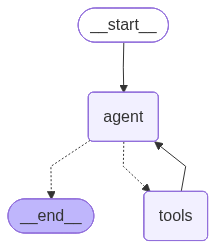

In [8]:
# 그래프 시각화
try:
    from IPython.display import Image, display
    display(Image(custom_react_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"그래프 시각화 실패: {e}")
    print("그래프 구조: START -> agent -> (tools -> agent) | END")

## 5. 테스트 케이스

In [9]:
def run_agent(query: str, agent=react_agent, verbose: bool = True):
    """에이전트를 실행하고 결과를 출력합니다."""
    if verbose:
        print(f"\n{'='*60}")
        print(f"Query: {query}")
        print(f"{'='*60}")
    
    response = agent.invoke({"messages": [("human", query)]})
    
    if verbose:
        for msg in response["messages"]:
            if msg.type == "human":
                continue
            elif msg.type == "ai":
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    print(f"\n[AI - Tool Calls]")
                    for tc in msg.tool_calls:
                        print(f"  -> {tc['name']}({tc['args']})")
                elif msg.content:
                    print(f"\n[AI - Final Response]")
                    print(f"  {msg.content}")
            elif msg.type == "tool":
                print(f"\n[Tool Result] {msg.name}: {msg.content}")
    
    return response

In [10]:
# 테스트 1: 수학 연산 (영어)
run_agent("Add 10 and 20, then divide the result by 3")


Query: Add 10 and 20, then divide the result by 3

[AI - Tool Calls]
  -> add({'a': 10, 'b': 20})

[Tool Result] add: 30

[AI - Tool Calls]
  -> divide({'a': 30, 'b': 3})

[Tool Result] divide: 10.0

[AI - Final Response]
  10


{'messages': [HumanMessage(content='Add 10 and 20, then divide the result by 3', additional_kwargs={}, response_metadata={}, id='d20c62b4-cf80-4bb1-b355-c206e41ce578'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-12-03T01:19:41.927438027Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6367322267, 'load_duration': 5608000188, 'prompt_eval_count': 218, 'prompt_eval_duration': 69952066, 'eval_count': 79, 'eval_duration': 603294818, 'logprobs': None, 'model_name': 'gpt-oss:20b', 'model_provider': 'ollama'}, id='lc_run--245d3f64-cf76-40c4-a134-a7321060f36a-0', tool_calls=[{'name': 'add', 'args': {'a': 10, 'b': 20}, 'id': 'bc92b47b-ef96-4704-8c3d-f31c5ef29b7b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 218, 'output_tokens': 79, 'total_tokens': 297}),
  ToolMessage(content='30', name='add', id='fc823b2f-9673-4337-a910-8ae948618c76', tool_call_id='bc92b47b-ef96-4704-8c3d-f31c5ef29b7b'),
  AIMessage(content=

In [11]:
# 테스트 2: 날씨 정보
run_agent("What is the weather in Seoul and Tokyo?")


Query: What is the weather in Seoul and Tokyo?

[AI - Tool Calls]
  -> get_weather({'city': 'Seoul'})

[Tool Result] get_weather: Sunny, 15°C

[AI - Tool Calls]
  -> get_weather({'city': 'Tokyo'})

[Tool Result] get_weather: Sunny, 22°C

[AI - Final Response]
  Here’s the current weather for each city:

| City | Weather | Temperature |
|------|---------|-------------|
| Seoul | Sunny | 15 °C |
| Tokyo | Sunny | 22 °C |

Let me know if you’d like more details (e.g., humidity, wind speed, forecast for the next few days, or anything else)!


{'messages': [HumanMessage(content='What is the weather in Seoul and Tokyo?', additional_kwargs={}, response_metadata={}, id='fa3c3b1f-b38c-41c9-922c-3c735cb13449'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-12-03T01:19:44.255225178Z', 'done': True, 'done_reason': 'stop', 'total_duration': 770919393, 'load_duration': 141306053, 'prompt_eval_count': 213, 'prompt_eval_duration': 124520424, 'eval_count': 63, 'eval_duration': 476482509, 'logprobs': None, 'model_name': 'gpt-oss:20b', 'model_provider': 'ollama'}, id='lc_run--d27ce87c-dbd5-459e-a469-99bed8f87667-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Seoul'}, 'id': '3354c9f2-0bcc-4344-8168-37c67d37c5c0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 213, 'output_tokens': 63, 'total_tokens': 276}),
  ToolMessage(content='Sunny, 15°C', name='get_weather', id='106deb30-c8ad-4bfc-b450-8954f052a952', tool_call_id='3354c9f2-0bcc-4344-8168-37c67d37c5c0'),


In [12]:
# 테스트 3: 복합 작업
run_agent("Multiply 7 by 8, then add 10 to the result")


Query: Multiply 7 by 8, then add 10 to the result

[AI - Tool Calls]
  -> multiply({'a': 7, 'b': 8})

[Tool Result] multiply: 56

[AI - Final Response]
  66


{'messages': [HumanMessage(content='Multiply 7 by 8, then add 10 to the result', additional_kwargs={}, response_metadata={}, id='45a4ef5e-7f3e-4efe-8810-d455cedf0998'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-12-03T01:19:46.603386221Z', 'done': True, 'done_reason': 'stop', 'total_duration': 943910193, 'load_duration': 134085036, 'prompt_eval_count': 218, 'prompt_eval_duration': 50526789, 'eval_count': 94, 'eval_duration': 714373986, 'logprobs': None, 'model_name': 'gpt-oss:20b', 'model_provider': 'ollama'}, id='lc_run--8b16889f-b8fe-4549-879e-e6b7e5df46db-0', tool_calls=[{'name': 'multiply', 'args': {'a': 7, 'b': 8}, 'id': '72f0cc00-e469-4fe6-a75e-a46fb0c204be', 'type': 'tool_call'}], usage_metadata={'input_tokens': 218, 'output_tokens': 94, 'total_tokens': 312}),
  ToolMessage(content='56', name='multiply', id='7cfb69be-d9b7-4c65-9d20-b25b8a566917', tool_call_id='72f0cc00-e469-4fe6-a75e-a46fb0c204be'),
  AIMessage(co

## 6. 한국어 테스트 (선택사항)

일부 로컬 모델은 한국어 지원이 제한적일 수 있습니다.

In [ ]:
# 한국어 테스트 (모델에 따라 결과가 다를 수 있음)
try:
    run_agent("5와 10을 더해줘")
except Exception as e:
    print(f"한국어 처리 중 오류: {e}")
    print("영어로 시도해보세요.")

## 7. 스트리밍 출력

In [ ]:
def run_agent_stream(query: str, agent=react_agent):
    """에이전트를 스트리밍 모드로 실행합니다."""
    print(f"\n{'='*60}")
    print(f"Query: {query}")
    print(f"{'='*60}")
    
    for event in agent.stream({"messages": [("human", query)]}, stream_mode="updates"):
        for node_name, node_output in event.items():
            print(f"\n[{node_name} node]")
            if "messages" in node_output:
                for msg in node_output["messages"]:
                    if hasattr(msg, "tool_calls") and msg.tool_calls:
                        for tc in msg.tool_calls:
                            print(f"  -> Tool call: {tc['name']}({tc['args']})")
                    elif hasattr(msg, "content") and msg.content:
                        content = str(msg.content)
                        print(f"  -> {content[:200]}..." if len(content) > 200 else f"  -> {content}")

In [ ]:
# 스트리밍 테스트
run_agent_stream("Multiply 5 and 7, then add 10 to the result")

## 8. 다른 로컬 모델 사용하기

In [ ]:
def create_agent_with_model(model_name: str):
    """다른 Ollama 모델로 에이전트를 생성합니다."""
    from langchain_ollama import ChatOllama
    from langgraph.prebuilt import create_react_agent
    
    local_llm = ChatOllama(
        model=model_name,
        base_url=OLLAMA_URL,
        temperature=0,
    )
    return create_react_agent(local_llm, tools)


# 예시: 다른 모델 사용
# other_agent = create_agent_with_model("gemma3:12b")
# run_agent("Add 5 and 3", agent=other_agent)

## 9. 요약

### 로컬 모델 사용의 장점
- **프라이버시**: 데이터가 외부로 전송되지 않음
- **비용**: API 호출 비용 없음
- **오프라인**: 인터넷 연결 없이 사용 가능
- **커스터마이징**: 모델 파인튜닝 가능

### 로컬 모델 사용 시 고려사항
- 추론 속도가 상대적으로 느림 (GPU 필요)
- 도구 호출 정확도가 상용 모델보다 낮을 수 있음
- 한국어 성능이 제한적일 수 있음
- 충분한 RAM/VRAM 필요 (최소 8GB 이상 권장)

### 권장 모델 (도구 호출 지원)
| 모델 | 크기 | 특징 |
|------|------|------|
| gemma3:4b | 4B | 경량, 빠름, 도구 호출 지원 |
| llama3.1 | 8B | 균형 잡힌 성능 |
| llama3.2 | 3B | 경량, 빠름 |
| mistral | 7B | 우수한 추론 |
| qwen2.5 | 7B | 다국어 지원 |